# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Libraries](#libraries)
2. [Load data](#load-data)
3. [Dataset overview](#dataset-overview)
4. [Data format conversion](#data-format-conversion)
5. [Dataset overview (single rider)](#possible-biases)
6. [Correlations](#correlations)


## 1. Libraries
Install and load necessary libraries.

In [ ]:
#Install necessary files
!pip install gpxpy
!pip install tcxreader

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpxpy
import gpxpy.gpx
import tcxreader
import tcxreader.tcxreader
import openpyxl
import os
import shutil


## 2. Load data
Load whole dataset containing all tracks of 9 riders.

In [ ]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Or upload local dataset
from google.colab import files
uploaded = files.upload()

In [ ]:
!unzip /content/drive/MyDrive/Sport1.zip -d /content

## 3. Dataset Overview
Basic exploration of the entire dataset.

In [ ]:
# Load gpx.
gpx_path = '/content/Sport/Sport/Rider1/f1.gpx'
with open(gpx_path) as f:
    gpx = gpxpy.parse(f)

# Convert to a dataframe one point at a time.
points = []
for segment in gpx.tracks[0].segments:
    for p in segment.points:
        points.append({
            'time': p.time,
            'latitude': p.latitude,
            'longitude': p.longitude,
            'elevation': p.elevation,
        })
df = pd.DataFrame.from_records(points)

# Number of samples
num_samples = df.shape[0]

# Number of features
num_features = df.shape[1]

# Display these dataset characteristics
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

# Display the first few rows of the dataframe to show the structure
print("Example data:")
print(df.head())



In [ ]:
# Path to the main folder containing Rider folders
main_path = '/content/Sport/Sport'

# Iterate through each Rider folder and count the number of .gpx files
for rider_folder in sorted(os.listdir(main_path)):
    folder_path = os.path.join(main_path, rider_folder)
    if os.path.isdir(folder_path):
        gpx_files = [f for f in os.listdir(folder_path) if f.endswith('.gpx')]
        tcx_files = [f for f in os.listdir(folder_path) if f.endswith('.tcx')]
        print(f"Folder '{rider_folder}' contains {len(gpx_files)} .gpx files and {len(tcx_files)} .tcx files.")


## 4. Data format conversion
Convert GPX and TCX to XLS format. In order to correctly analyse all the data its format should be firstly unified.

In [ ]:
def convert_gpx_to_excel(gpx_file_path, output_file_path):
  # Initialize a DataFrame to store data
  all_data = []

  # Parse the GPX file
  with open(gpx_file_path, 'r') as gpx_file:
      gpx = gpxpy.parse(gpx_file)

  # Extract data (latitude, longitude, elevation, time, etc.)
  for track in gpx.tracks:
      for segment in track.segments:
          for point in segment.points:
              # Convert timezone-aware datetime to timezone-naive
              naive_time = point.time.replace(tzinfo=None) if point.time else None

              all_data.append({
                  'Latitude': point.latitude,
                  'Longitude': point.longitude,
                  'Elevation': point.elevation,
                  'Time': naive_time
              })

  # Convert the data into a DataFrame
  df = pd.DataFrame(all_data)

  # Write the DataFrame to an Excel file
  df.to_excel(output_file_path, index=False)


In [ ]:
# TCX to XLSX
def convert_tcx_to_excel(tcx_file_path, output_file_path):
    """
    Converts a TCX file to an Excel file with trackpoint data.

    Parameters:
    - tcx_file_path: str, path to the input TCX file
    - output_file_path: str, path to save the output Excel file
    """
    # Initialize the TCX reader
    tcx_reader = TCXReader()

    # Read the TCX file
    data: TCXExercise = tcx_reader.read(tcx_file_path)

    # List to store the trackpoint data
    trackpoint_data = []

    # Loop through all trackpoints and extract relevant information
    for trackpoint in data.trackpoints:
        trackpoint_data.append({
            'Time': trackpoint.time,
            'Latitude': trackpoint.latitude,
            'Longitude': trackpoint.longitude,
            'Elevation': trackpoint.elevation,
            'Distance': trackpoint.distance,
            'Heartrate': trackpoint.hr_value,
            'Cadence': trackpoint.cadence,
            'Speed': trackpoint.tpx_ext['Speed']
        })

    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(trackpoint_data)

    # Save the DataFrame to an Excel file
    df.to_excel(output_file_path, index=False, engine='openpyxl')


In [ ]:
# Define the directories
sport_dir = "/content/Sport/Sport"
sport_xlsx_dir = "/content/Sport_xlsx"

# Create Sport_xlsx directory if it doesn't exist
if not os.path.exists(sport_xlsx_dir):
    os.makedirs(sport_xlsx_dir)

# Function to convert files in a folder
def convert_files_in_folder(rider_folder):
    rider_xlsx_folder = os.path.join(sport_xlsx_dir, rider_folder)

    # Create the rider folder in Sport_xlsx directory if it doesn't exist
    if not os.path.exists(rider_xlsx_folder):
        os.makedirs(rider_xlsx_folder)

    rider_folder_path = os.path.join(sport_dir, rider_folder)

    # Process .gpx files
    gpx_files = [f for f in os.listdir(rider_folder_path) if f.endswith('.gpx')]
    for gpx_file in gpx_files:
        convert_gpx_to_excel(os.path.join(rider_folder_path, gpx_file),
                           os.path.join(rider_xlsx_folder, gpx_file.replace('.gpx', '.xlsx')))

    # Process .tcx files
    tcx_files = [f for f in os.listdir(rider_folder_path) if f.endswith('.tcx')]
    for tcx_file in tcx_files:
        convert_tcx_to_excel(os.path.join(rider_folder_path, tcx_file),
                           os.path.join(rider_xlsx_folder, tcx_file.replace('.tcx', '.xlsx')))


In [ ]:
#Riders = ['Rider1', 'Rider2', 'Rider3', 'Rider4', 'Rider5', 'Rider6', 'Rider7', 'Rider8', 'Rider9']
Riders = ['Rider2']
for rider in Riders:
  convert_files_in_folder(rider)

In [ ]:
!zip -r /content/Sport_xlsx/Rider2.zip /content/Sport_xlsx/Rider2

# 5. Dataset overview (Single rider)
Load and exploration of a single rider files after succesful conversion to xlsx format.

In [ ]:
!unzip /content/drive/MyDrive/Rider1.zip -d /content

In [44]:
directory = '/content/content/Sport_xlsx/Rider1/'

# Initialize lists and dictionaries to store results
row_counts = []

# Loop through all files in the directory
for file in os.listdir(directory):
    if file.endswith(".xlsx"):
        file_path = os.path.join(directory, file)

        # Read the Excel file
        df = pd.read_excel(file_path)

        # Count rows and add to list
        row_counts.append(df.shape[0])

        # Count missing values by column
        if missing_values is None:
          missing_values = df.isnull().sum()
        else:
          missing_values += df.isnull().sum()

In [29]:
# Print the missing values summary
print(missing_values)

Latitude     0
Longitude    0
Elevation    0
Time         0
dtype: int64


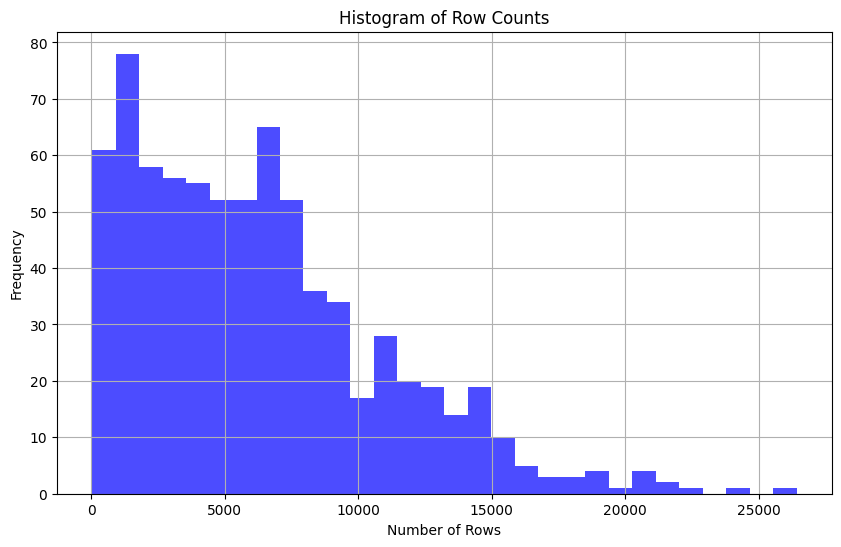

In [30]:
# Plot the histogram of row counts
plt.figure(figsize=(10, 6))
plt.hist(row_counts, bins=30, color='blue', alpha=0.7)
plt.title("Histogram of Row Counts")
plt.xlabel("Number of Rows")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

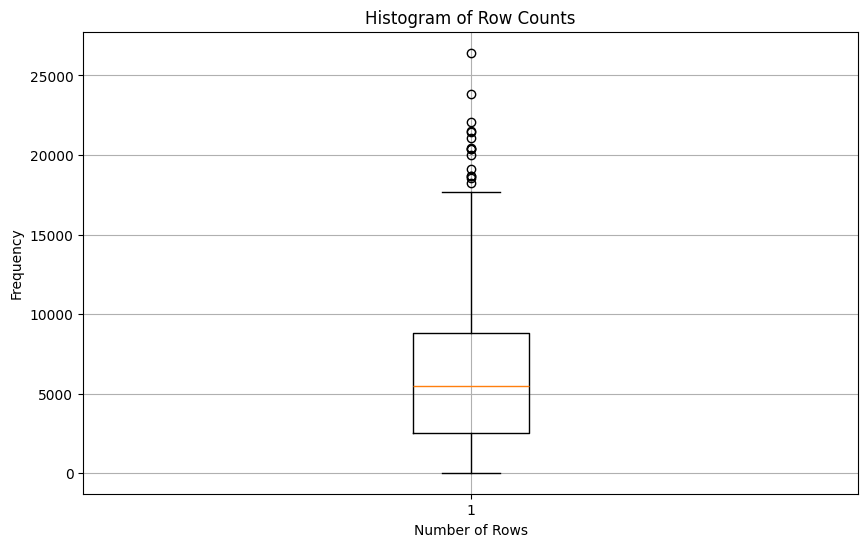

In [31]:
# Plot the boxplot of row counts
plt.figure(figsize=(10, 6))
plt.boxplot(row_counts)
plt.title("Boxplot of Row Counts")
plt.grid(True)
plt.show()

In [78]:
print(sorted(row_counts))

[26, 27, 34, 38, 70, 79, 101, 106, 199, 206, 210, 212, 266, 274, 285, 286, 327, 334, 349, 357, 371, 374, 387, 402, 406, 429, 438, 455, 469, 473, 474, 513, 526, 550, 555, 560, 601, 603, 611, 612, 644, 650, 660, 664, 698, 749, 750, 758, 765, 767, 772, 804, 807, 808, 817, 821, 841, 843, 878, 894, 898, 910, 913, 919, 933, 942, 949, 952, 990, 995, 1004, 1026, 1046, 1057, 1058, 1064, 1066, 1072, 1101, 1138, 1169, 1175, 1180, 1187, 1198, 1201, 1209, 1232, 1274, 1276, 1286, 1302, 1302, 1318, 1321, 1331, 1338, 1339, 1360, 1363, 1380, 1381, 1391, 1394, 1404, 1423, 1424, 1424, 1428, 1431, 1431, 1437, 1476, 1483, 1498, 1502, 1512, 1519, 1524, 1542, 1549, 1549, 1586, 1619, 1623, 1644, 1660, 1665, 1673, 1682, 1685, 1689, 1694, 1726, 1729, 1733, 1747, 1772, 1775, 1797, 1800, 1813, 1824, 1833, 1836, 1846, 1852, 1877, 1894, 1917, 1927, 1944, 1961, 1979, 2013, 2026, 2037, 2038, 2047, 2052, 2057, 2064, 2099, 2099, 2104, 2187, 2189, 2200, 2201, 2202, 2226, 2240, 2253, 2265, 2268, 2272, 2275, 2300, 2300, 2

In [67]:
directory = '/content/content/Sport_xlsx/Rider1/'

# Initialize lists and dictionaries to store results
total_seconds = []

# Loop through all files in the directory
for file in os.listdir(directory):
    if file.endswith(".xlsx"):
        file_path = os.path.join(directory, file)

        # Read the Excel file
        df = pd.read_excel(file_path)

        # Convert timestamps to absolute value
        df['Time'] = pd.to_datetime(df['Time'])
        df['Time'] = (df['Time'] - df['Time'][0]).dt.total_seconds()

        # Count length of each file
        total_seconds.append(df['Time'].iloc[-1])

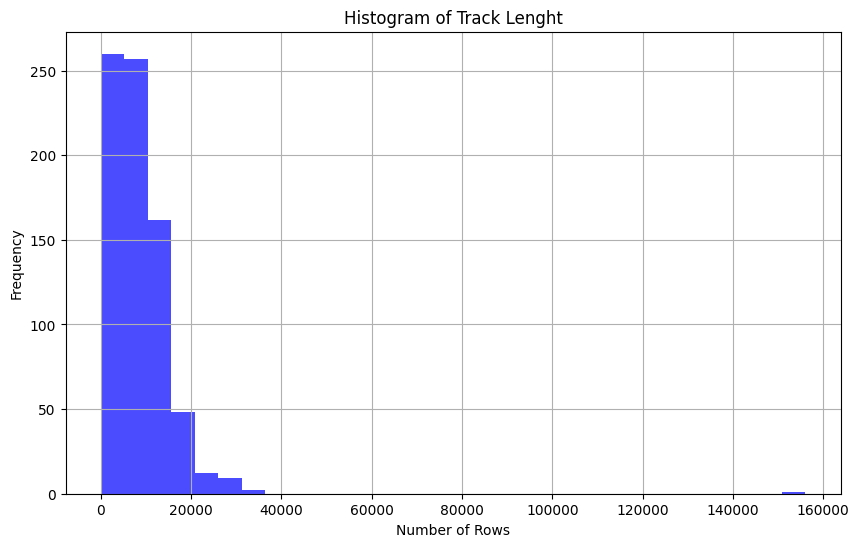

In [68]:
# Plot the histogram of file lengths
plt.figure(figsize=(10, 6))
plt.hist(total_seconds, bins=30, color='blue', alpha=0.7)
plt.title("Histogram of Track Lenght")
plt.xlabel("Number of Rows")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

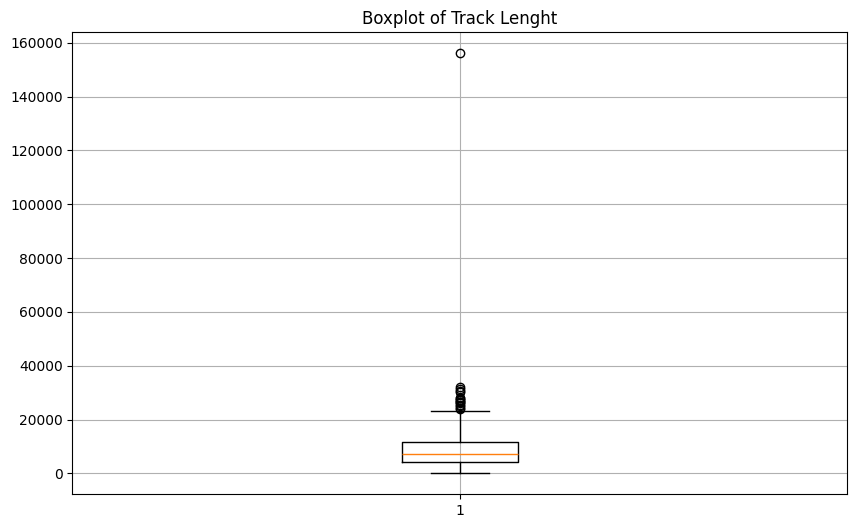

In [69]:
# Plot the boxplot of file lenghts
plt.figure(figsize=(10, 6))
plt.boxplot(total_seconds)
plt.title("Boxplot of Track Lenght")
plt.grid(True)
plt.show()

In [74]:
print(sorted(total_seconds))

[27.0, 42.0, 108.0, 135.0, 195.0, 213.0, 282.0, 382.0, 408.0, 445.0, 458.0, 475.0, 518.0, 576.0, 586.0, 623.0, 661.0, 674.0, 697.0, 716.0, 766.0, 820.0, 857.0, 881.0, 927.0, 954.0, 1020.0, 1034.0, 1072.0, 1088.0, 1101.0, 1160.0, 1188.0, 1199.0, 1210.0, 1230.0, 1231.0, 1257.0, 1274.0, 1284.0, 1327.0, 1365.0, 1367.0, 1393.0, 1400.0, 1417.0, 1432.0, 1435.0, 1441.0, 1447.0, 1451.0, 1451.0, 1457.0, 1481.0, 1508.0, 1511.0, 1514.0, 1519.0, 1523.0, 1525.0, 1527.0, 1559.0, 1559.0, 1620.0, 1628.0, 1649.0, 1652.0, 1665.0, 1701.0, 1768.0, 1773.0, 1806.0, 1807.0, 1833.0, 1837.0, 1919.0, 1939.0, 1947.0, 1953.0, 1980.0, 1983.0, 2020.0, 2020.0, 2038.0, 2054.0, 2057.0, 2063.0, 2120.0, 2127.0, 2142.0, 2182.0, 2193.0, 2205.0, 2246.0, 2280.0, 2302.0, 2304.0, 2320.0, 2335.0, 2378.0, 2384.0, 2391.0, 2534.0, 2546.0, 2559.0, 2567.0, 2569.0, 2599.0, 2612.0, 2621.0, 2653.0, 2662.0, 2675.0, 2701.0, 2705.0, 2726.0, 2734.0, 2760.0, 2763.0, 2820.0, 2821.0, 2840.0, 2844.0, 2847.0, 2851.0, 2874.0, 2887.0, 2895.0, 292